# RL Agent Using Double DQN


- Environment: [MountainCar](https://gym.openai.com/envs/MountainCar-v0/)
- Policy: Epsilon Gready Policy
- Number of Actions: 3
- Number of States: 2 * 200,000 * 3 = 1,200,000


Developed by:
- Daniel Addai-Marnu <daniel.addai-marnu@city.ac.uk>

## Description of Environment

A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Details about the states, reward and solved policy is available here: https://github.com/openai/gym/wiki/MountainCar-v0

# How to Run the Notebook

Upload the notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and run the notebook. This will install ensure all python requirements are available to execute the notebook. 

# Install and Import Packages

In [0]:
!pip install -q -U gym
!apt-get install python-opengl -y -qq
!apt install xvfb -y -qq

!pip install -q pyvirtualdisplay piglet millify

Selecting previously unselected package python-opengl.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Selecting previously unselected package xvfb.
(Reading database ... 146788 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 


In [0]:
import sys
import math
import glob
import io
import base64
from itertools import count
import math
import time
from collections import defaultdict, deque, namedtuple
from datetime import datetime
from dataclasses import dataclass
import copy
import os

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torch.autograd as autograd

from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
from millify import millify
# setup gym display for virtual environment when running in Google Colab
gymlogger.set_level(40) # error only

IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    display = Display(visible=0, size=(1400, 900))
    display.start()

# set up matplotlib
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.dpi']= 110
sns.set_style('darkgrid')

# function to view recorded training videos
def show_video(recording_dir='video', index=-1):
    """
    Utility functions to enable video recording of gym environment and displaying it
    To enable video, just do "env = wrap_env(env)""
    """
    mp4list = glob.glob('./recordings/{}/*.mp4'.format(recording_dir))
    if len(mp4list) > 0:
        mp4 = mp4list[index]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")


# gym monitor wrapper
def wrap_env(env, recording_dir='video'):
    env = Monitor(env, './recordings/'+recording_dir, force=True)
    return env

# ensure output folders are created
os.makedirs('models', exist_ok=True)
os.makedirs('metrics', exist_ok=True)
os.makedirs('charts', exist_ok=True)
os.makedirs('recordings', exist_ok=True)

# if gpu is to be used
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


cuda:0


# Test environment

Here we load the MountainCar-v0 and test how it works

In [0]:
# load the environment
env = gym.make('MountainCar-v0')
# wrap the environment with the video recorder for rendering online
env = wrap_env(env)

# get initial observation
observation = env.reset()
total_reward = 0
# execute some random actions
for timesteps in count(start=1):
    action = env.action_space.sample()
    next_state, reward, is_done, info = env.step(action)
    total_reward += reward

    if is_done:
        print("Task completed in {} steps || total reward: {}".format(timesteps, total_reward))
        break

env.close()
show_video() # show video

Task completed in 200 steps || total reward: -200.0


For each step taken, the agent receives a reward of -1 until it reaches the goal position (indicated with the flag). There is limited time of 200 steps to complete the task. The reward system makes it difficult for the agent to learn from the actions taken. For this reason we'll adjust the reward for the environment accordingly

# Adjust Environment Reward

We adjusted the reward by adding 0.5 to the location of the car for each action and +500 for reaching the goal position. This is to ensure the agent learns to take action that moves the car upward.

In [0]:
class RewardWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        """
        Adjust reward based on car's position and tasks completion
        """
        # observation = (position, velocity)
        observation, reward, done, info = self.env.step(action)
        # set counter for goal position
        info['goal_position'] = 0
        # adjust reward based on car's position
        if observation[0] >= self.env.goal_position:  # goal location
            reward = 500
            info['goal_position'] = 1
        elif observation[0] >= -0.4: # starting position
            reward += observation[0] + 0.5
                
        return observation, reward, done, info


# DQN

## Define Deep Learning models

We make use of Multi-Layer Perceptron to train the agent

In [0]:

class MLP(nn.Module):
    """Create MLP model"""
    def __init__(self, n_states, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(n_states, 30)
        self.fc2 = nn.Linear(30, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Test the MLP

In [0]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
mlp = MLP(n_states, n_actions)
print(mlp)

MLP(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=3, bias=True)
)


In [0]:
state = env.observation_space.sample()
state = torch.tensor(state)
out = mlp(state)
print('MLP output:', out)

MLP output: tensor([-0.3721,  0.0512, -0.0350], grad_fn=<AddBackward0>)


### Define DQN functions

In [0]:
# path to save model checkpoints
MODEL_PATH = "./models"

In [0]:
# state transitions container
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state'))

class Metrics:
    """
    Class to accumate scores during the training process
    e.g.
    metrics = Metrics()
    metrics.add('steps', 120) 
    metrics.save('agent') # write metrics to csv
    """

    def __init__(self, path, resume=True):
        self.data = defaultdict(list)
        self.path = '{}/{}.csv'.format(MODEL_PATH, path)

        if resume and os.path.exists(self.path): # reload metrics when resuming training
            df = pd.read_csv(self.path)
            for key, val in df.to_dict().items():
                self.data[key].extend(val.values())

    def add(self, key, record):
        self.data[key].append(record)

    def __getitem__(self, key: str):
        return self.data[key]

    def to_dataframe(self):
        return pd.DataFrame(self.data)
    
    def save(self):
        df = self.to_dataframe()
        df.to_csv(self.path, index=False)


class ArgMaxActionStrategy:

    def __repr__(self):
        return "ArgMaxActionStrategy"

    def __call__(self, scores):
        # use exploitation
        action = scores.argmax(dim=1)
        return action


class EpsilonGreedyStrategy:
    """
    Selects actions using Epsilon Greedy Policy. Initialte the class with the starting epsilon value,
    min value and decay rate. For each timestep the epsilon is reduced by the decay rate until it
    reaches the minimum value.
    """

    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def __repr__(self):
        return "EpsilonGreedyStrategy(start={}, end={}, decay={})".format(
            self.start, self.end, self.decay
        )
    
    def __call__(self, scores):
        if np.random.randn() < self.start:
            # Epsilon-Greedy action exploration
            action = np.random.randint(0, scores.shape[1])
            action = torch.tensor([action])
        else:
            # use exploitation
            action = scores.argmax(dim=1)
        
        # decrease epsilon
        if self.start > self.end:
            self.start *= self.decay
        return action


class ReplayMemory:
    """
    Experience replay memory
    """
    
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size) 
        
    def push(self, state, action, reward, next_state):
        experience = (state, action, np.array([reward]), next_state)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        batch = Experience(*zip(*experiences))

        states = torch.cat(batch.state).to(DEVICE)
        actions = torch.LongTensor(batch.action).to(DEVICE)
        rewards = torch.FloatTensor(batch.reward).to(DEVICE)
        next_states = torch.cat(batch.next_state).to(DEVICE)
        
        return (states, actions, rewards, next_states)
    
    def can_provide_sample(self, batch_size):
        return len(self.buffer) >= batch_size


class DQN:

    def __init__(self, env, strategy, alpha=0.01, gamma=0.98, batch_size=32, 
                 target_update_counter=100, model_name='dqn', resume=True):
        self.env = env
        self.device = DEVICE
        self.model_name = model_name
        # create policy net
        self.lr = alpha
        self.policy_net = self.build_model()
        self.policy_path = '{}/{}_policy.pth'.format(MODEL_PATH, model_name)
        # clone policy net
        self.target_net = copy.deepcopy(self.policy_net)
        # set target net to eval
        self.target_net.eval()
        # set model training parameters
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.optimizer_path = '{}/{}_optimizer.pth'.format(MODEL_PATH, model_name)
        self.criterion = torch.nn.MSELoss()
        # set agent learning parameters
        self.memory = ReplayMemory(10000)
        self.batch_size = batch_size
        self.gamma = gamma
        self.strategy = strategy
        self.steps_counter = 0
        # update target network for every 1000th episode
        self.target_update_counter = target_update_counter
        if resume:
            self.load_checkpoints()

    def build_model(self):
        n_states = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n
        return MLP(n_states, n_actions).to(DEVICE)

    def __repr__(self):
        return "DQN(model=MLP, lr={}, gamma={}, strategy={})".format(
            self.lr, self.gamma, self.strategy
        )

    def update_target_net(self):
        # Update the target network, copying all weights and biases in DQN
        if self.steps_counter % self.target_update_counter == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state):
        """Make agent predict actions using the strategy"""
        with torch.no_grad():
            scores = self.policy_net(state)
        
        action = self.strategy(scores)
        return action.to(DEVICE)

    @torch.no_grad()
    def predict(self, state):
        """Estimate action using the model"""
        return self.policy_net(state).argmax(dim=1).to(DEVICE)

    def learn(self, state, action, reward, next_state):
        """
        Make agent learn.
        Adapted from: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training-loop
        """
        # store transition state
        self.memory.push(state, action, reward, next_state)
        # check if memory can provide sample
        if not self.memory.can_provide_sample(self.batch_size):
            return
        # update target network
        self.steps_counter += 1
        self.update_target_net()
        # get samples
        states, actions, rewards, next_states = self.memory.sample(self.batch_size)
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        current_q_values = self.policy_net.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        # Compute V(s_{t+1}) for all next states using target_net; 
        # selecting their best reward with max(1)[0]
        next_q_values = self.target_net(next_states)
        max_next_Q = torch.max(next_q_values, 1)[0]
        # Compute the expected Q values
        target_q_values = rewards.squeeze(1) + self.gamma * max_next_Q
        # Compute Huber loss
        loss = self.criterion(current_q_values, target_q_values)
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def save_checkpoints(self):
        torch.save(self.policy_net.state_dict(), self.policy_path)
        torch.save(self.optimizer.state_dict(), self.optimizer_path)

    def load_checkpoints(self):
        if os.path.exists(self.optimizer_path):
            print("resuming training with policy state from file")
            self.policy_net.load_state_dict(
                torch.load(self.policy_path)
            )
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_net.eval()
        
        if os.path.exists(self.optimizer_path):
            print("resuming training with optimizer state from file")
            self.optimizer.load_state_dict(
                torch.load(self.optimizer_path)
            )

    def eval(self):
        self.policy_net.eval()

### Define agent training functions

In [0]:
def print_progress(str):
    """Function print progress"""
    print('\n', str)
    ipythondisplay.clear_output(wait=True)


def train(agent, env, episodes=10000):
    """
    Function to train an agent for a given environment and number of episodes
    """
    print('Training agent for {} episodes'.format(episodes))
    # initialize best average reward
    best_reward = -math.inf
    # initialize metrics container
    metrics = Metrics(agent.model_name)
    # initialize starting time
    start_time = time.time()
    # number of completion streaks
    goal_position_streaks = 0
    # start episode interaction
    for episode in range(1, episodes+1):
        obs = env.reset()
        total_reward = 0.0
        running_loss = 0.0
        # train agent to solve the environment
        for timesteps in count(start=1):
            # agent makes decision
            action = agent.act(obs)
            # execute action on environment
            next_state, reward, done, info = env.step(action.item())
            # cumulate episode reward
            total_reward += reward
            total_reward = round(total_reward, 3)
            # make agent learn 
            loss = agent.learn(obs, action, reward, next_state)
            if loss:
                running_loss += loss
                running_loss = round(running_loss, 3)
            # update previous state with next state
            obs = next_state
            # check if environment is solved
            if done:
                # update metrics
                metrics.add('steps', timesteps)
                metrics.add('rewards', total_reward)
                metrics.add('loss', loss)
                metrics.add('goal_positions', info['goal_position'])

                # track consecutive goal streaks
                if info['goal_position'] > 0:
                    goal_position_streaks += 1
                else:
                    goal_position_streaks = 0

                break

        # update best reward
        if total_reward > best_reward:
            best_reward = total_reward
    
        running_loss /= timesteps

        if episode % 10 == 0:
            agent.save_checkpoints() # periodic saving of policy to prevent retraining when it crashes
            metrics.save()
            
            print_progress('Episode#: {}/{}, steps: {}, reward: {}, best reward: {}, loss: {}, goal position streaks: {}'.format(
                episode, episodes, timesteps, total_reward, best_reward, running_loss, goal_position_streaks)
            )

        # implement early stoping if the agent manages to solve the environment for 100 consecutive times
        if episode >= 1000 and goal_position_streaks >= 100:
            print('\nTask complete\n')
            break

    time_elapsed = time.time() - start_time
    print('Training complete || Best reward: {:.2f} || Time spent: {:.0f}m {:.0f}s, streaks: {}'.format(
        best_reward, time_elapsed // 60, time_elapsed % 60, goal_position_streaks
    ))
    agent.save_checkpoints()
    # close environment
    env.close()
    # return metrics
    metrics.save()
    return metrics.to_dataframe()


def test(agent, env, episodes=100):
    """
    Function to test a trained agent for athe given environment
    """
    # set the model to evaluation mode to prevent training
    agent.eval()
    # define metrics collector
    metrics = Metrics(agent.model_name, resume=False)

    for episode in range(episodes):
        obs = env.reset()
        total_reward = 0.0
        for timesteps in count(start=1):
            # select action from the best Q-values
            action = agent.act(obs)
            next_state, reward, done, info = env.step(action.item())
            obs = next_state
            total_reward += reward

            if done:
                break

        metrics.add('rewards', total_reward)
        metrics.add('steps', timesteps)
        metrics.add('goal_position', info['goal_position'])
        print("Episode#: {}, reward: {}, goal position reached: {}".format(
            episode, total_reward, 'Yes' if info['goal_position'] else 'No'
        ))
    # close environment
    env.close()
    return metrics.to_dataframe()

# Train the Q-Agent

In [0]:
class ScaleObservation(gym.ObservationWrapper):
    """
    Scale state space to create a lower representation of the observation using N size
    This puts the observation received from the environment into N * 2 bins
    """

    def __init__(self, env, N):
        super().__init__(env)
        self.scaler = self.state_space(env, N)

    @staticmethod
    def state_space(env, N):
        
        state_space_samples = np.array([env.observation_space.sample() for _ in range(N)])
        print("State size: ({}, {}, {})".format(*state_space_samples.shape, env.action_space.n))

        scaler = StandardScaler()
        scaler.fit(state_space_samples)

        def wrapper(state):
            scaled = scaler.transform([state])
            return scaled[0]

        return wrapper

    def observation(self, observation):
        return self.scaler(observation)


class ObservationTensor(gym.ObservationWrapper):

    def observation(self, observation):
        return torch.FloatTensor(observation).unsqueeze(0).to(DEVICE)


def make_env(recording_dir='videos', max_episode_steps=None, state_size=None):
    """Create environment with higher timelimit and reward changes"""
    env = gym.make('MountainCar-v0').unwrapped
    env = RewardWrapper(env)

    if max_episode_steps: # wrap environment with time limit
        env = gym.wrappers.TimeLimit(env, max_episode_steps=max_episode_steps)
    if state_size: # wrap environment with scaler
        env = ScaleObservation(env, N=state_size)

    env = wrap_env(env, recording_dir=recording_dir)
    env = ObservationTensor(env)
    
    # to ensure reproducibility
    env.seed(110)
    np.random.seed(10)
    return env


def plot_scores(metrics, rolling_window=100, title="Training scores", format_ticks=True, filename='qagent'):
    """Plot scores and optional rolling mean using specified window."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    
    rolling_means = metrics.rolling(rolling_window).mean()
    
    ax1.plot(metrics['steps'], label="Time steps", alpha=0.3, linewidth=1, markersize=5)
    ax1.plot(rolling_means['steps'], label="Moving average", linewidth=1, markersize=0.5)
    ax1.set_xlabel("Episodes")
    ax1.set_title("Steps")
    if format_ticks:
        xticks = [millify(x, precision=1) for x in ax1.get_xticks()]
        ax1.set_xticklabels(xticks)

    ax1.legend(loc='best')
    
    ax2.plot(metrics['rewards'], label="Rewards", alpha=0.3, linewidth=1, markersize=0.5)
    ax2.plot(rolling_means['rewards'], label="Moving average", linewidth=1, markersize=0.5)
    ax2.set_title("Rewards")
    ax2.legend(loc='best')
    ax2.set_xlabel("Episodes")
    if format_ticks:
        xticks = [millify(x, precision=1) for x in ax2.get_xticks()]
        ax2.set_xticklabels(xticks)
    
    plt.suptitle(title)
    plt.savefig('charts/scores_{}.jpg'.format(filename))
    plt.show()

In [0]:
# define training parameters
NUM_EPISODES = 5000 # five thousand episodes
TARGET_UPDATE_COUNTER = 100 # update target network for every 10 episode
STATES_SIZE = 200000  # number of bins to discritize states: 200000 * 2 *3 = 1,200,000

## Trial 1 - Using Epsilon Greedy Policy

```
Epsilon values: start=0.9, end=0.01, decay=0.9999995
Alpha = 0.001
Gamma = 0.98
```

In [0]:
# load environment 
env = make_env(recording_dir='agent1', max_episode_steps=500, state_size=STATES_SIZE)
env

State size: (200000, 2, 3)


<ObservationTensor<Monitor<ScaleObservation<TimeLimit<RewardWrapper<MountainCarEnv<MountainCar-v0>>>>>>>

In [0]:
# define agent strategy
strategy = EpsilonGreedyStrategy(start=0.9, end=0.01, decay=0.99995)
# create agent
agent1 = DQN(env, strategy, alpha=0.001, gamma=0.98, model_name='agent1', 
             target_update_counter=TARGET_UPDATE_COUNTER)
agent1

DQN(model=MLP, lr=0.001, gamma=0.98, strategy=EpsilonGreedyStrategy(start=0.9, end=0.01, decay=0.99995))

In [0]:
# start the training process
metrics = train(agent1, env, episodes=NUM_EPISODES)


Task complete

Training complete || Best reward: 371.78 || Time spent: 25m 26s, streaks: 100


We defined the environment is solved when the car reaches the goal position for 100 consecutive episodes. The training time was 25 minutes and the best reward earned was 371.78

In [0]:
#show video
show_video('agent1')

### Visualize training scores

In [0]:
metrics.tail(10)

,steps,rewards,loss,goal_positions
1193,287,240.594,5527.487305,1
1194,195,337.613,22349.019531,1
1195,175,351.517,15538.203125,1
1196,171,363.770,4255.859375,1
1197,176,357.781,2589.947998,1
1198,254,280.113,3674.287109,1
1199,160,366.643,3243.975586,1
1200,298,238.718,2331.231445,1
1201,176,354.210,4755.138672,1
1202,304,234.361,18053.152344,1


In [0]:
metrics.describe()

,steps,rewards,loss,goal_positions
count,1203.000000,1203.000000,1203.000000,1203.000000
mean,284.173732,202.537874,2533.632305,0.892768
std,103.178990,241.114633,3730.110170,0.309537
min,149.000000,-500.000000,0.000878,0.000000
25%,208.000000,219.228500,412.608063,1.000000
50%,250.000000,293.852000,1361.206055,1.000000
75%,333.000000,326.748500,2617.352783,1.000000
max,500.000000,371.778000,24528.355469,1.000000


From the above table, it took about 1,200 episodes for the agent to complete training. Also, we observe that, 89% of the episodes successfully reached the goal position.

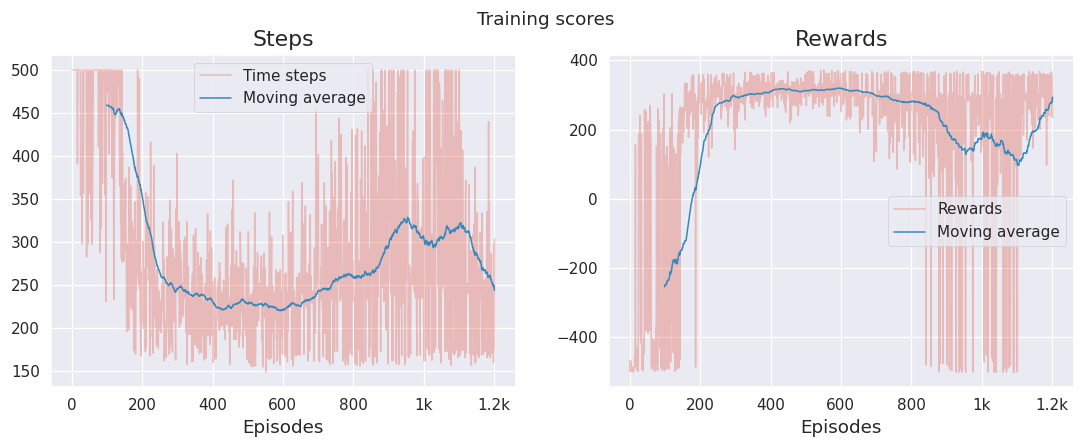

In [0]:
# plot the training steps and reward
plot_scores(metrics, rolling_window=100)

You should observe the mean episode timesteps go down over time while the average reward increase over time. Next, we freeze learning and run the agent in test mode to see how well it performs.

### Test agent on the environment

We used the trained model to solve the environment.

In [0]:
# test the trained policy for 100 episodes
test_df1 = test(agent1, env)

Episode#: 0, reward: 203.86195183387554, goal position reached: Yes
Episode#: 1, reward: 285.1028331899049, goal position reached: Yes
Episode#: 2, reward: 357.150368329618, goal position reached: Yes
Episode#: 3, reward: 256.7809758146035, goal position reached: Yes
Episode#: 4, reward: 296.8608599689353, goal position reached: Yes
Episode#: 5, reward: 207.13776589413516, goal position reached: Yes
Episode#: 6, reward: 159.4995366870226, goal position reached: Yes
Episode#: 7, reward: 287.4543017290881, goal position reached: Yes
Episode#: 8, reward: 229.59520263899316, goal position reached: Yes
Episode#: 9, reward: 209.1469991282397, goal position reached: Yes
Episode#: 10, reward: 292.44171464286853, goal position reached: Yes
Episode#: 11, reward: 359.7900408206694, goal position reached: Yes
Episode#: 12, reward: 287.18126429578734, goal position reached: Yes
Episode#: 13, reward: 300.1955687359667, goal position reached: Yes
Episode#: 14, reward: 156.18659054241255, goal positio

In [0]:
test_df1.tail(100)

,rewards,steps,goal_position
0,203.861952,332,1
1,285.102833,258,1
2,357.150368,171,1
3,256.780976,294,1
4,296.860860,264,1
...,...,...,...
95,282.677440,246,1
96,299.822115,242,1
97,295.541247,259,1
98,277.279647,258,1


In [0]:
test_df1.describe()

,rewards,steps,goal_position
count,100.000000,100.000000,100.00
mean,276.979084,257.130000,0.99
std,91.751996,62.882391,0.10
min,-445.797006,157.000000,0.00
25%,264.575317,237.500000,1.00
50%,291.285004,254.000000,1.00
75%,302.151339,280.750000,1.00
max,370.461072,500.000000,1.00


From the above, the agent reached the goal position in all the 100 episodes.

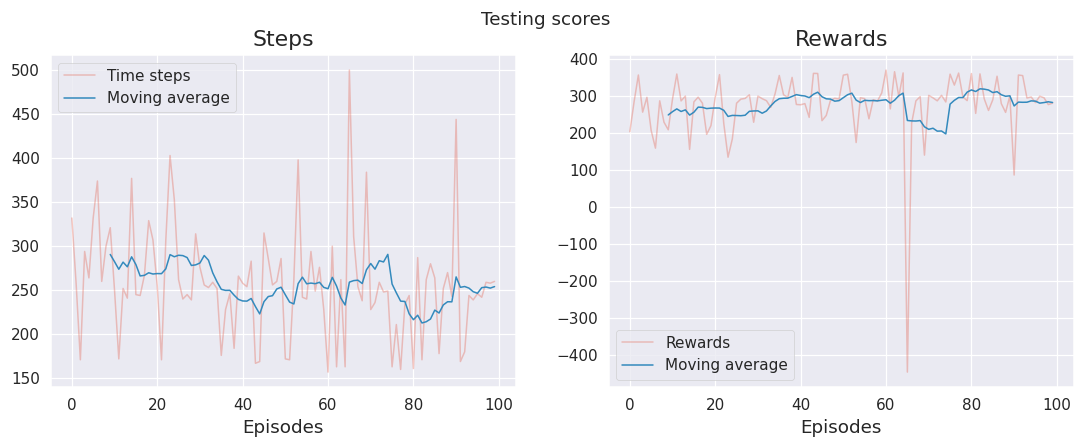

In [0]:
# visualize the test scores
plot_scores(test_df1, rolling_window=10, title='Testing scores', format_ticks=False, filename='agent1_test')

## Trial 2 - Keep Epsilon and gamma constant, increase alpha

```
Epsilon values: start=0.9, end=0.01, decay=0.9999995
Alpha = 0.01
Gamma = 0.98
```

In [0]:
# load environment 
env = make_env(recording_dir='agent2', max_episode_steps=500, state_size=STATES_SIZE)
env

State size: (200000, 2, 3)


<ObservationTensor<Monitor<ScaleObservation<TimeLimit<RewardWrapper<MountainCarEnv<MountainCar-v0>>>>>>>

In [0]:
# define agent strategy
strategy = EpsilonGreedyStrategy(start=0.9, end=0.01, decay=0.99995)
# create agent
agent2 = DQN(env, strategy, alpha=0.01, gamma=0.98, model_name='agent2', 
             target_update_counter=TARGET_UPDATE_COUNTER)
agent2

DQN(model=MLP, lr=0.01, gamma=0.98, strategy=EpsilonGreedyStrategy(start=0.9, end=0.01, decay=0.99995))

In [0]:
# start the training process
metrics2 = train(agent2, env, episodes=NUM_EPISODES)


Task complete

Training complete || Best reward: 372.64 || Time spent: 81m 32s, streaks: 100


In [0]:
show_video('agent2')

### Visualize training scores

In [0]:
metrics2.tail(10)

,steps,rewards,loss,goal_positions
3858,298,231.825,3793.028320,1
3859,269,266.186,1371.246338,1
3860,247,301.481,4492.395996,1
3861,264,282.714,3221.284180,1
3862,373,173.431,1316.603516,1
3863,240,297.109,11561.585938,1
3864,468,76.174,1319.432617,1
3865,315,226.894,1285.494629,1
3866,183,352.467,10981.298828,1
3867,253,291.196,787.523682,1


In [0]:
metrics2.describe()

,steps,rewards,loss,goal_positions
count,3868.00000,3868.000000,3868.000000,3868.000000
mean,433.81696,-217.739174,604.492838,0.364271
std,100.82333,344.865193,1790.380502,0.481287
min,152.00000,-500.000000,0.000257,0.000000
25%,356.00000,-490.276000,0.317643,0.000000
50%,500.00000,-460.401500,19.131817,0.000000
75%,500.00000,203.756500,421.245789,1.000000
max,500.00000,372.643000,21671.638672,1.000000


It took about 3,800 episodes for each the agent to complete training. However, this agent didn't perform well as we observe only 36% of the episodes reached the goal position.

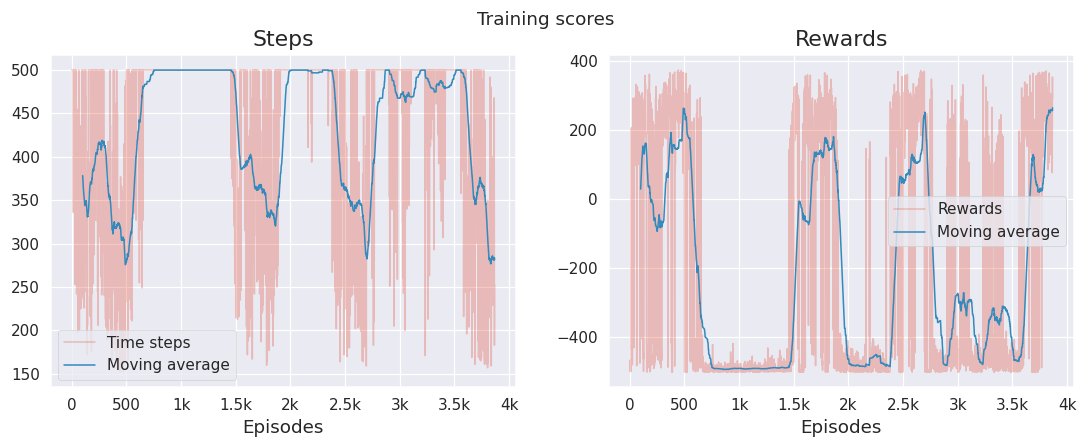

In [0]:
plot_scores(metrics2, rolling_window=100)

The training was not stable using a lower alpha value as we observe upwards and downward trend. Next, we freeze learning and run the agent in test mode to see how well it performs.

### Test agent on the environment

We used the trained model to solve the environment.

In [0]:
# test the trained policy for 100 episodes
test_df2 = test(agent2, env)

Episode#: 0, reward: 220.3512925970502, goal position reached: Yes
Episode#: 1, reward: 215.03597823679257, goal position reached: Yes
Episode#: 2, reward: 171.80591360056985, goal position reached: Yes
Episode#: 3, reward: 292.3120922607005, goal position reached: Yes
Episode#: 4, reward: 287.770223013597, goal position reached: Yes
Episode#: 5, reward: 296.45904512183205, goal position reached: Yes
Episode#: 6, reward: 290.92274597166534, goal position reached: Yes
Episode#: 7, reward: 220.60198645822305, goal position reached: Yes
Episode#: 8, reward: 202.97042749957575, goal position reached: Yes
Episode#: 9, reward: 142.80379838332397, goal position reached: Yes
Episode#: 10, reward: 295.13563065976496, goal position reached: Yes
Episode#: 11, reward: 289.8449263568798, goal position reached: Yes
Episode#: 12, reward: 234.45656510605505, goal position reached: Yes
Episode#: 13, reward: 236.89920364174452, goal position reached: Yes
Episode#: 14, reward: 277.0037527850475, goal pos

In [0]:
test_df2.tail(100)

,rewards,steps,goal_position
0,220.351293,345,1
1,215.035978,350,1
2,171.805914,393,1
3,292.312092,259,1
4,287.770223,257,1
...,...,...,...
95,227.633967,336,1
96,293.734171,259,1
97,289.955114,275,1
98,229.960650,328,1


In [0]:
test_df2.describe()

,rewards,steps,goal_position
count,100.000000,100.000000,100.00
mean,233.561386,322.580000,0.99
std,84.879701,68.906932,0.10
min,-421.885431,168.000000,0.00
25%,209.987016,268.500000,1.00
50%,228.248386,330.000000,1.00
75%,287.511709,368.250000,1.00
max,367.731180,500.000000,1.00


Supprisingly, the agent performed relatively good in testing phase. This means, we'll require more training time to stabilize the reward and steps.

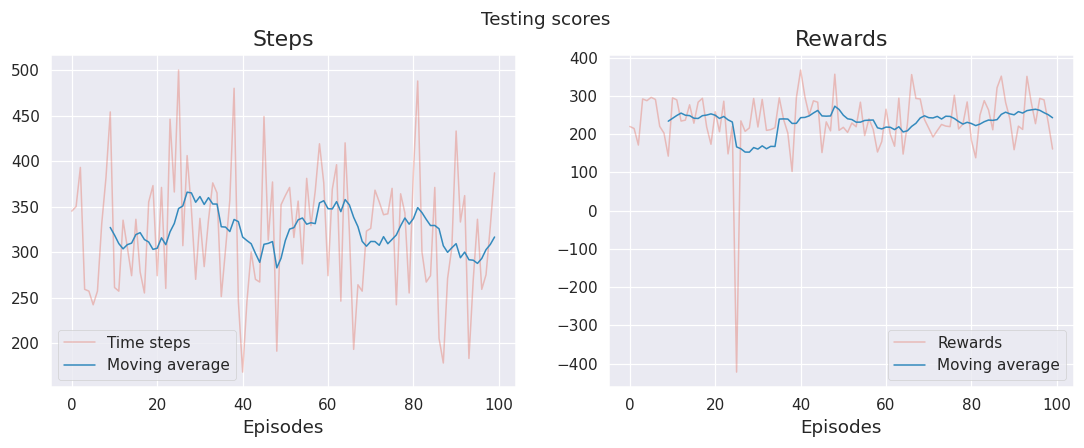

In [0]:
# visualize the test scores
plot_scores(test_df2, rolling_window=10, title='Testing scores', format_ticks=False, filename='agent2_test')

# Test comparison

## Rewards

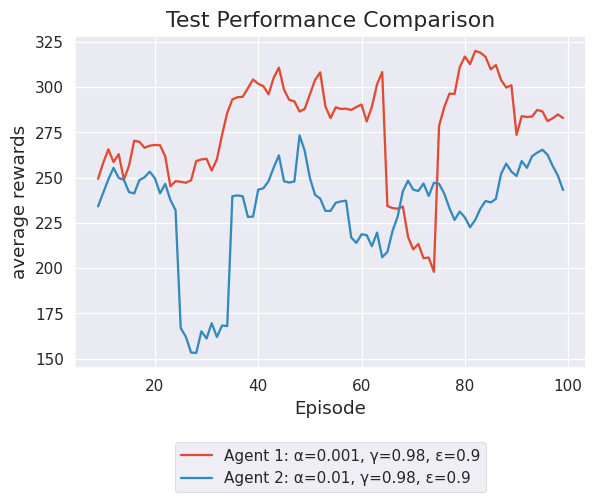

In [0]:
fig, ax = plt.subplots()
ax.plot(test_df1.rewards.rolling(10).mean(), label='Agent 1: α=0.001, γ=0.98, ε=0.9')
ax.plot(test_df2.rewards.rolling(10).mean(), label='Agent 2: α=0.01, γ=0.98, ε=0.9')

ax.set_xlabel('Episode')
ax.set_ylabel('average rewards')

plt.title('Test Performance Comparison')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20))
plt.show()

Overall, Agent 1 with lower alpha value earned higher rewards than Agent 2.

## Steps

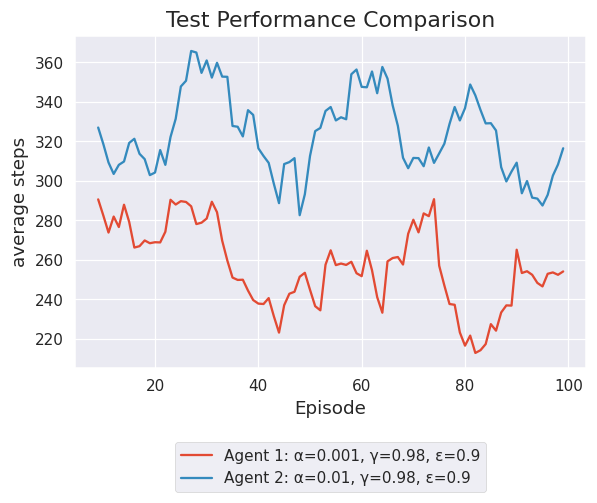

In [0]:
fig, ax = plt.subplots()
ax.plot(test_df1.steps.rolling(10).mean(), label='Agent 1: α=0.001, γ=0.98, ε=0.9')
ax.plot(test_df2.steps.rolling(10).mean(), label='Agent 2: α=0.01, γ=0.98, ε=0.9')

ax.set_xlabel('Episode')
ax.set_ylabel('average steps')

plt.title('Test Performance Comparison')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20))
plt.show()

Agent 1 made fewer steps than Agent 2 to reach the goal position